In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
from sklearn.cross_validation import train_test_split

import edward as ed

from edward.models import WishartFull, WishartCholesky, MultivariateNormalCholesky, MultivariateNormalFull, Empirical
from tensorflow.contrib.linalg import LinearOperatorTriL

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%load_ext autoreload

In [3]:
ed.__version__, tf.__version__, np.__version__

('1.2.1', '1.0.1', '1.12.1')

In [4]:
D = 2
N = 10000
cov = np.array([[1.5, 0.2],[0.2, 0.1]])
X = sps.multivariate_normal.rvs(mean = np.zeros(D), cov = cov, size=N)

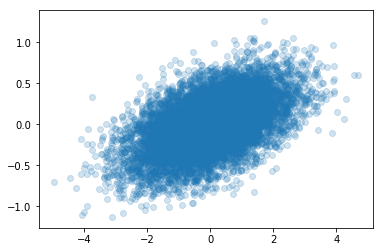

In [5]:
plt.scatter(*X.T,alpha=.2);

## probabilistic model

In [6]:
# priors
v_prior = tf.Variable(3., dtype=tf.float32, trainable=False)
W_prior = tf.Variable(np.array([[1., 0.], [0., 1.]]),
                      dtype=tf.float32, trainable=False)
m_prior = tf.Variable(np.array([0.5, 0.5]), dtype=tf.float32, trainable=False)
k_prior = tf.Variable(0.6, dtype=tf.float32, trainable=False)

In [7]:
#x = MultivariateNormalFull(mu=tf.zeros([n, d]), sigma=tf.stack([tf.eye(d)]*n))
sigma = WishartFull(df=v_prior, scale=W_prior)
mu = MultivariateNormalFull(m_prior, k_prior * sigma,name="Mercutio")
#mu = MultivariateNormalFull(m_prior, k_prior * tf.matmul(tf.cholesky(sigma),tf.cholesky(sigma),transpose_b=True),name="Mercutio")
#mu = MultivariateNormalFull(m_prior, W_prior,name="Mercutio")
xn = MultivariateNormalFull(tf.reshape(tf.tile(mu, [N]), [N, D]),
                            tf.reshape(tf.tile(sigma, [N, 1]), [N, D, D]),name="Alfred")

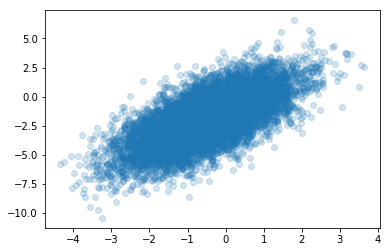

In [8]:
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    X_sample = xn.sample().eval()
    plt.scatter(*X_sample.T,alpha=.2);

In [9]:
print('***** PROBABILISTIC MODEL *****')
print('mu: {}'.format(mu))
print('sigma: {}'.format(sigma))
print('xn: {}'.format(xn))

***** PROBABILISTIC MODEL *****
mu: <ed.RandomVariable 'Mercutio/' shape=(2,) dtype=tf.float32>
sigma: <ed.RandomVariable 'WishartFull/' shape=(2, 2) dtype=tf.float32>
xn: <ed.RandomVariable 'Alfred/' shape=(10000, 2) dtype=tf.float32>


## variational model

In [10]:
m = tf.Variable(tf.random_normal([D], dtype=tf.float32))
R_seed = tf.random_normal([D, D], dtype=tf.float32)
R = tf.Variable(R_seed)
RRT = tf.matmul(R,R,transpose_b=True) # + D * tf.eye(D, dtype=tf.float32)

#qmu = MultivariateNormalCholesky(m, tf.cholesky(RRT))
qmu = MultivariateNormalCholesky(m, LinearOperatorTriL(R).to_dense())
#L = tf.nn.softplus(
#        tf.Variable(tf.random_normal([D, D], dtype=tf.float32)))
L = tf.Variable(tf.random_normal([D, D], dtype=tf.float32))
LLT = tf.matmul(L,L,transpose_b=True) # + D * tf.eye(D, dtype=tf.float32)

qsigma = WishartCholesky(
    tf.nn.softplus(
        tf.Variable(tf.random_normal([], dtype=tf.float32))+D+1),
    #LinearOperatorTriL(L).to_dense()
    LinearOperatorTriL(L).to_dense()
    , name = "Zeratul")
#qsigma = WishartFull(tf.Variable(tf.random_normal([], dtype=tf.float32))),
#    LLT
#    , name = "Zeratul")

m = tf.Variable(tf.random_normal([D], dtype=tf.float32))

qmu = MultivariateNormalCholesky(m, tf.Variable(np.array([[1., 0.], [0., 1.]]),
                      dtype=tf.float32, trainable=False))

qsigma = WishartCholesky(
    tf.nn.softplus(
        tf.Variable(tf.random_normal([], dtype=tf.float32))),
    tf.Variable(np.array([[1., 0.], [0., 1.]]),
                      dtype=tf.float32, trainable=False)
    , name = "Zeratul")

In [19]:
inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={xn: X})
#inference.initialize(n_print=100, optimizer=tf.train.GradientDescentOptimizer(1e-3), n_samples=200)
inference.initialize(n_print=100, n_samples=30)

qmu2 = Empirical(params=tf.Variable(tf.zeros((1000,2))))
qsigma2 = Empirical(params=tf.Variable(tf.zeros((1000,2,2))))

inference2 = ed.HMC({mu: qmu2, sigma: qsigma2}, data={xn: X})

inference2.initialize(n_print=1)

In [20]:
#%%debug
#inference.initialize(scale={x: float(N)}, var_list=[qmu, qsigma], n_samples=20)
sess = ed.get_session()
#init = tf.initialize_all_variables()
init = tf.global_variables_initializer()
init.run()

print(np.tril(L.eval()).dot(np.tril(L.eval()).T))

inference.update()
#print(np.tril(L.eval()).dot(np.tril(L.eval()).T))

In [21]:
#%%debug
for t in range(2000):
    info_dict = inference.update()
    inference.print_progress(info_dict)

Iteration    1 [  0%]: Loss = 163409.469
Iteration  100 [ 10%]: Loss = 23120.312
Iteration  200 [ 20%]: Loss = 22651.539
Iteration  300 [ 30%]: Loss = 23972.996
Iteration  400 [ 40%]: Loss = 22724.566
Iteration  500 [ 50%]: Loss = 24697.840
Iteration  600 [ 60%]: Loss = 22210.441
Iteration  700 [ 70%]: Loss = 21642.791
Iteration  800 [ 80%]: Loss = 22703.701
Iteration  900 [ 90%]: Loss = 22410.521
Iteration 1000 [100%]: Loss = 25261.871
Iteration 1100 [110%]: Loss = 21929.504
Iteration 1200 [120%]: Loss = 26817.564
Iteration 1300 [130%]: Loss = 22605.625
Iteration 1400 [140%]: Loss = 21733.096
Iteration 1500 [150%]: Loss = 22763.447
Iteration 1600 [160%]: Loss = 21771.910
Iteration 1700 [170%]: Loss = 21028.658
Iteration 1800 [180%]: Loss = 21957.969
Iteration 1900 [190%]: Loss = 23552.604
Iteration 2000 [200%]: Loss = 23673.707


In [25]:
mu_est = qmu.mean().eval()

In [26]:
sigma_est = qsigma.mode().eval()

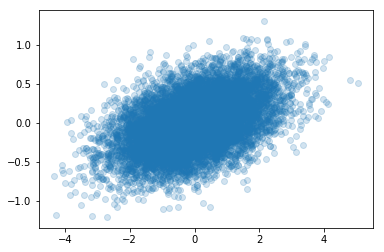

In [31]:
plt.scatter(*MultivariateNormalFull(mu_est, sigma_est).sample(10000).eval().T,alpha=.2)